In [157]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, Embedding
from tensorflow.keras.models import Model



In [158]:
# ฟังก์ชันสำหรับการดึงคุณลักษณะจากไฟล์เสียง (MFCC)
def extract_features(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=14)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((14, max_pad_len))

In [159]:
def load_data(audio_folder):
    filenames = []
    labels = []
    for emotion in os.listdir(audio_folder):
        emotion_folder = os.path.join(audio_folder, emotion)
        if os.path.isdir(emotion_folder):
            for filename in os.listdir(emotion_folder):
                if filename.endswith(".wav"):
                    file_path = os.path.join(emotion_folder, filename)
                    filenames.append(file_path)
                    labels.append(emotion)
    return filenames, labels



In [160]:
# ฟังก์ชันสร้าง Positional Encoding
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)

def multi_head_attention(query, key, value, num_heads):
    batch_size = tf.shape(query)[0]  # ใช้ tf.shape เพื่อดึงขนาดของ batch_size
    d_model = query.shape[-1]  # d_model จาก query

    if d_model % num_heads != 0:
        raise ValueError(f"d_model ({d_model}) ต้องหาร num_heads ({num_heads}) ลงตัว")

    depth = d_model // num_heads

    # ปรับรูปทรงเพื่อทำ multi-head attention
    query = tf.reshape(query, (batch_size, -1, num_heads, depth))  # (batch_size, seq_len, num_heads, depth)
    key = tf.reshape(key, (batch_size, -1, num_heads, depth))      # (batch_size, seq_len, num_heads, depth)
    value = tf.reshape(value, (batch_size, -1, num_heads, depth))  # (batch_size, seq_len, num_heads, depth)

    query = tf.transpose(query, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)
    key = tf.transpose(key, perm=[0, 2, 1, 3])      # (batch_size, num_heads, seq_len, depth)
    value = tf.transpose(value, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    # คำนวณ attention
    attention_scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
    attention_scores = attention_scores / tf.math.sqrt(tf.cast(depth, tf.float32))
    attention_weights = tf.nn.softmax(attention_scores, axis=-1)

    # คำนวณผลลัพธ์
    attention_output = tf.matmul(attention_weights, value)  # (batch_size, num_heads, seq_len, depth)
    attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)
    attention_output = tf.reshape(attention_output, (batch_size, -1, d_model))  # (batch_size, seq_len, d_model)

    return attention_output



In [161]:
def transformer_block(inputs, num_heads, dff, d_model, dropout_rate=0.1):
    print(f'Input shape before attention: {inputs.shape}')  # ตรวจสอบขนาดของ inputs ก่อนการทำงาน
    # ตรวจสอบให้แน่ใจว่าอินพุตมีรูปทรงถูกต้อง: (batch_size, seq_length, d_model)
    if len(inputs.shape) == 2:  # ถ้ามีแค่ (seq_length, d_model) เพิ่ม batch dimension
        inputs = tf.expand_dims(inputs, axis=0)  # เปลี่ยนรูปทรงเป็น (1, seq_length, d_model)
    
    print(f'Input shape after expanding dimensions: {inputs.shape}')  # ตรวจสอบขนาดหลังการขยายมิติ
    # ใช้ multi-head attention ที่รับ inputs อยู่ในรูป (batch_size, seq_length, d_model)
    attention_output = multi_head_attention(inputs, inputs, inputs, num_heads)
    print(f'Attention output shape: {attention_output.shape}')  # ตรวจสอบขนาดหลังการทำ attention

    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = Dense(dff, activation='relu')(attention_output)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return ffn_output


In [162]:
def extract_features_from_all(filenames, max_pad_len=100):
    features = []
    for file in filenames:
        mfccs = extract_features(file, max_pad_len)
        features.append(mfccs)
    return np.array(features)


In [163]:
def create_transformer_model(input_shape, num_classes, num_heads=4, dff=256, d_model=128, num_layers=2, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    pos_enc = positional_encoding(input_shape[0], d_model)  # ใช้ shape ที่ถูกต้อง
    x = Dense(d_model)(inputs)
    
    # เพิ่ม positional encoding
    x = x + pos_enc
    print(f'Input shape after adding positional encoding: {x.shape}')  # ตรวจสอบขนาดหลังการเพิ่ม positional encoding
    
    for _ in range(num_layers):
        x = transformer_block(x, num_heads, dff, d_model, dropout_rate)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [164]:
train_folder = '/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/train'
val_folder = '/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/val'
test_folder = '/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/test'
train_filenames, train_labels = load_data(train_folder)
test_filenames, test_labels = load_data(test_folder)
val_filenames, val_labels = load_data(val_folder)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)
y_test_encoded = label_encoder.transform(test_labels)
y_val_encoded = label_encoder.transform(val_labels)
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)
y_val_encoded = to_categorical(y_val_encoded)
X_train_features = extract_features_from_all(train_filenames)
X_test_features = extract_features_from_all(test_filenames)
X_val_features = extract_features_from_all(val_filenames)
# เพิ่มมิติข้อมูลสำหรับ RNN
X_test = X_test_features
X_train = X_train_features  # ไม่เพิ่มมิติ
X_val = X_val_features  # ไม่เพิ่มมิติ


In [165]:
n_classes = len(label_encoder.classes_)
input_shape = (X_train.shape[1], X_train.shape[2])  # (14, 100)
model = create_transformer_model(input_shape, n_classes)


Input shape after adding positional encoding: (None, 14, 128)
Input shape before attention: (None, 14, 128)
Input shape after expanding dimensions: (None, 14, 128)


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
print(f"Input shape: {input_shape}")


Input shape: (14, 100)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=50, validation_data=(X_val, y_val_encoded), callbacks=[early_stop])


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1973 - loss: 2.4327 - val_accuracy: 0.6143 - val_loss: 1.1033
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4495 - loss: 1.5653 - val_accuracy: 0.7250 - val_loss: 0.8108
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5699 - loss: 1.1966 - val_accuracy: 0.7786 - val_loss: 0.6520
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6389 - loss: 1.0159 - val_accuracy: 0.8036 - val_loss: 0.5214
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7321 - loss: 0.7850 - val_accuracy: 0.8250 - val_loss: 0.4479
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7370 - loss: 0.7354 - val_accuracy: 0.8536 - val_loss: 0.4103
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8082 - loss: 0.5531 - val_accuracy: 0.8929 - val_loss: 0.3265
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8297 - loss: 0.5029 - val_accuracy: 0.9000 - val_loss

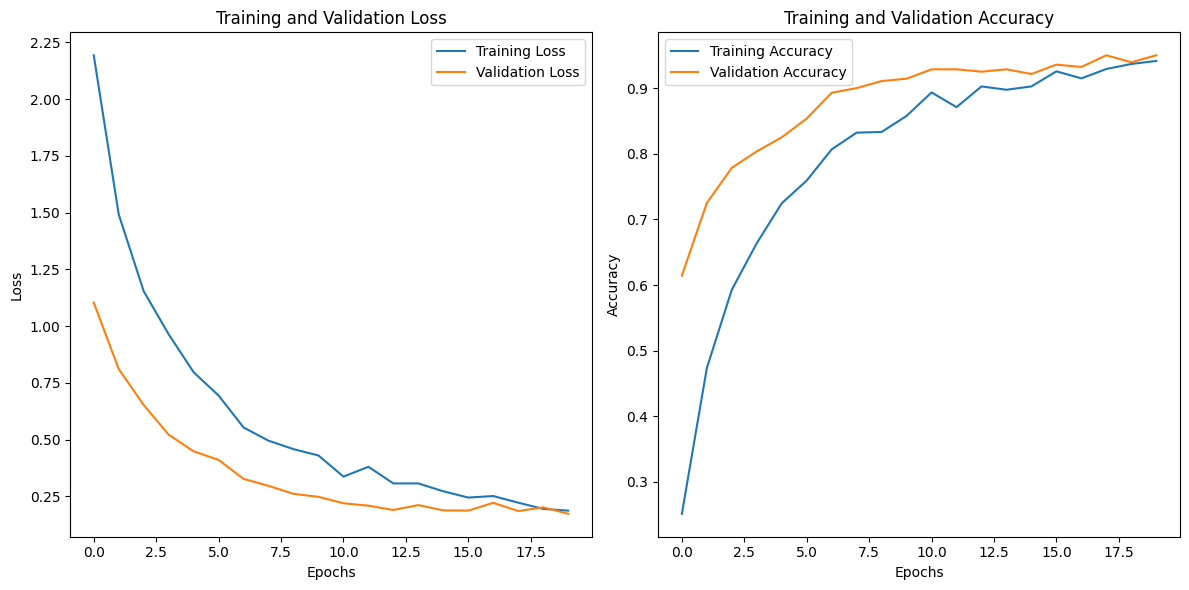

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9450 - loss: 0.2060 
Test Loss: 0.16338522732257843
Test Accuracy: 0.9446428418159485


In [ ]:
# ทำนายข้อมูลทดสอบ
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # หาคลาสที่ทำนาย
true_classes = np.argmax(y_test_encoded, axis=1)  # หาคลาสจริง

# คำนวณความแม่นยำในการทำนาย
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Accuracy: {accuracy*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 94.46%


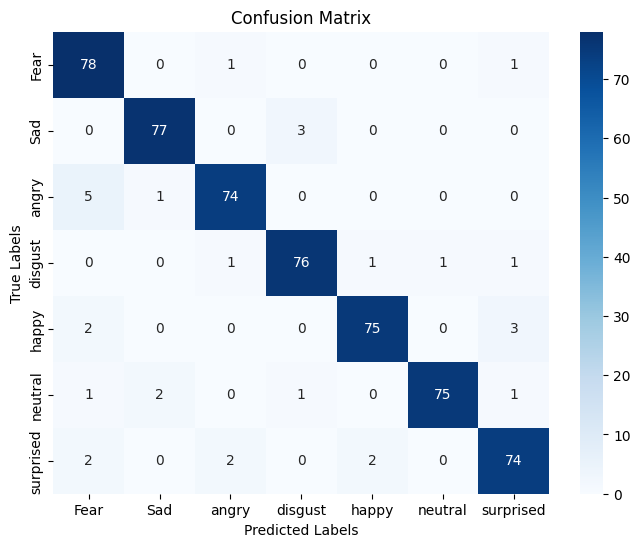

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# บันทึกโมเดล
model.save('emotion_recognition_model.h5')
